### import

In [19]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

import os

import urllib3
urllib3.disable_warnings()

import keras

from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import time

### datasets

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

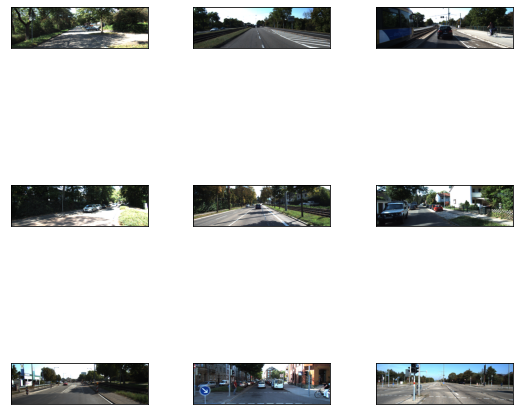

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

In [5]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.79], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.19883783, 0.8690278 , 0.6165946 , 0.927933  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.85, 0.67, 1.1 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6.21, 1.38, 8.9 ]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}


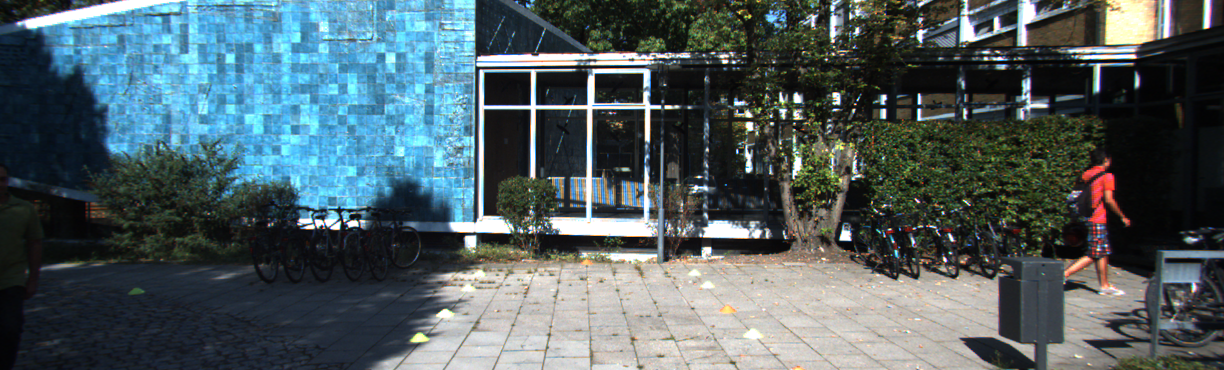

In [6]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1224  height: 370
(1, 4)
[1063.6901  296.43   1135.7899  141.86  ]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7FA7B411C1D0>


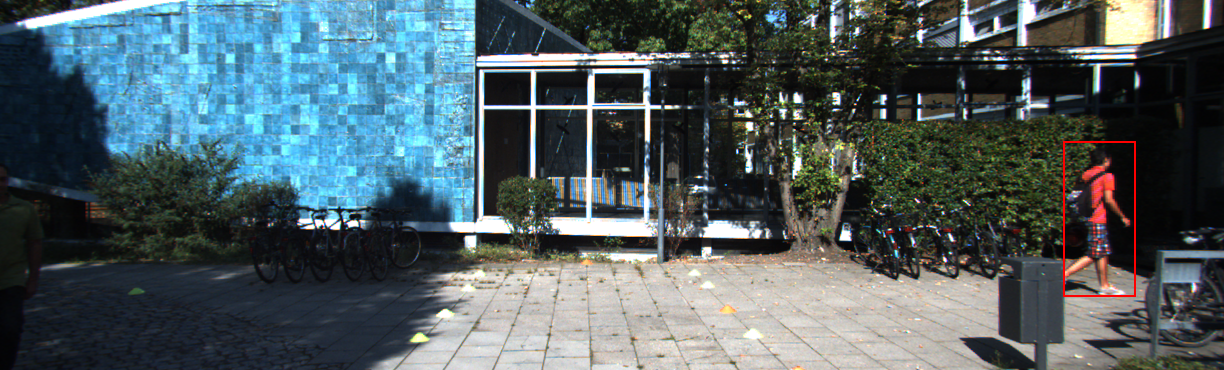

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 클래스 및 바운딩 박스 정보 추출

In [9]:
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

In [10]:
# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

In [11]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:06<00:00,  8.74it/s]


In [12]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:27<00:00,  8.15it/s]


### 클래스 맵핑

In [14]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [15]:
save_class_format(class_txt_path)

### 학습

In [17]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-26 14:09:07.511034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 14:09:08.469205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 14:09:08.469783: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 14:09:08.496395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 14:09:08.497039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-26 14:09:08.497073: I tensorflow/stream_executor/platform/def

2021-04-26 14:09:11.982971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-26 14:09:11.983530: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-26 14:09:17.616094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-26 14:09:18.648189: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-26 14:09:18.685190: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-26 14:09:18.987961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
195/195 [===========================

195/195 [==============================] - 67s 340ms/step - loss: 1.0738 - regression_loss: 0.8344 - classification_loss: 0.2394

Epoch 00020: saving model to ./snapshots/resnet50_csv_20.h5
Epoch 21/50
195/195 [==============================] - 68s 344ms/step - loss: 1.1004 - regression_loss: 0.8405 - classification_loss: 0.2600

Epoch 00021: saving model to ./snapshots/resnet50_csv_21.h5

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 22/50
195/195 [==============================] - 65s 329ms/step - loss: 1.1215 - regression_loss: 0.8600 - classification_loss: 0.2615

Epoch 00022: saving model to ./snapshots/resnet50_csv_22.h5
Epoch 23/50
195/195 [==============================] - 66s 335ms/step - loss: 1.0646 - regression_loss: 0.8160 - classification_loss: 0.2486

Epoch 00023: saving model to ./snapshots/resnet50_csv_23.h5

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 24/50
195/195 [====================

195/195 [==============================] - 61s 309ms/step - loss: 1.0985 - regression_loss: 0.8331 - classification_loss: 0.2655

Epoch 00041: saving model to ./snapshots/resnet50_csv_41.h5
Epoch 42/50
195/195 [==============================] - 62s 316ms/step - loss: 1.0835 - regression_loss: 0.8308 - classification_loss: 0.2526

Epoch 00042: saving model to ./snapshots/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.
Epoch 43/50
195/195 [==============================] - 62s 314ms/step - loss: 1.0239 - regression_loss: 0.7822 - classification_loss: 0.2417

Epoch 00043: saving model to ./snapshots/resnet50_csv_43.h5
Epoch 44/50
195/195 [==============================] - 61s 312ms/step - loss: 1.0944 - regression_loss: 0.8242 - classification_loss: 0.2702

Epoch 00044: saving model to ./snapshots/resnet50_csv_44.h5

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
Epoch 45/50
195/195 [=====================

In [187]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_20.h5 snapshots/resnet50_csv_20_infer.h5

2021-04-26 22:09:06.936289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 22:09:07.811986: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 22:09:07.812572: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 22:09:07.835478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 22:09:07.835787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-26 22:09:07.835806: I tensorflow/stream_executor/platform/def

### 시각화

In [189]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_20_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [190]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

In [191]:
def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()  

[593.57965 175.76308 625.64    206.28865]
[189.78738 130.66588 360.21967 233.77553]


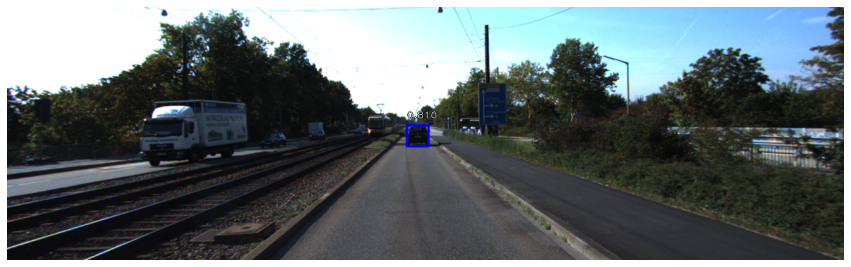

In [192]:
inference_on_image(model, img_path=img_path)

[773.27124 151.30511 846.1146  316.9587 ]
[766.3756  147.85606 849.8446  318.2218 ]


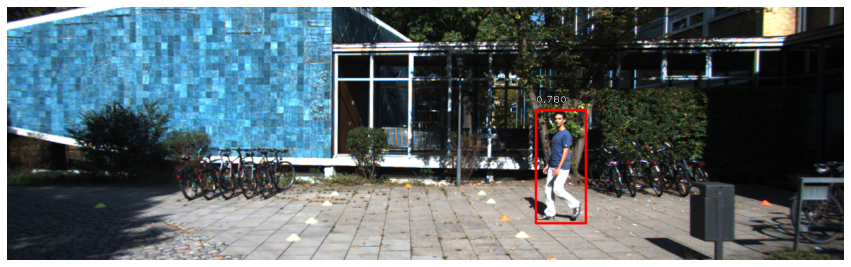

In [193]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

### 1. 자율주행 시스템 만들기

In [194]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

In [217]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    sign = 'Go'
    # display images 
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)

        if score < 0.4897:
            break
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

        """
        정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
        조건은 다음과 같습니다.
            사람이 한 명 이상 있는 경우
            차량의 크기(width or height)가 300px이상인 경우
        """
        print(box[2]-box[0], box[3]-box[1])
        if (label==1) or (label==0 and (box[2]-box[0] >= size_limit or box[3]-box[1] >= size_limit)):
            sign = 'Stop'
            break

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()      
    return sign

[773.27124 151.30511 846.1146  316.9587 ]
72.84338 165.6536


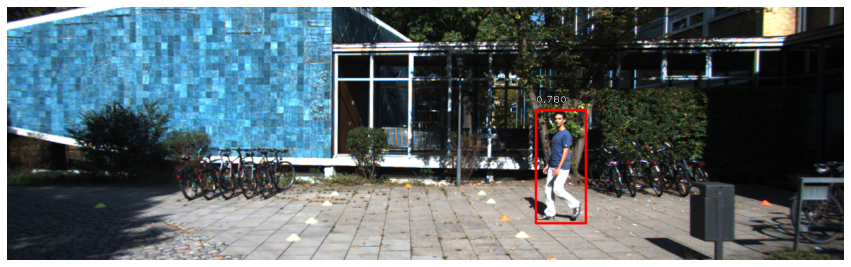

Stop


In [218]:
print(self_drive_assist(img_path))   

### 2. 자율주행 시스템 평가하기

In [219]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

[773.27124 151.30511 846.1146  316.9587 ]
72.84338 165.6536


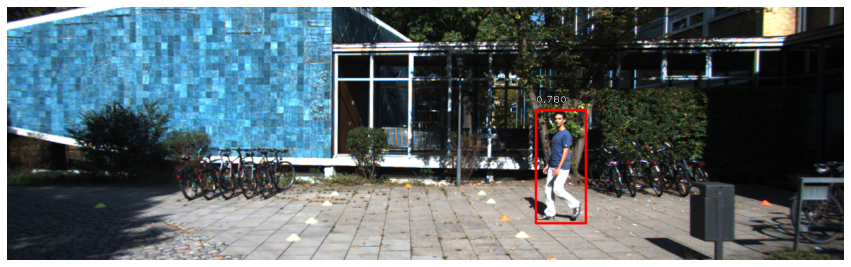

[413.32074 163.58122 503.8436  338.47964]
90.52286 174.89842


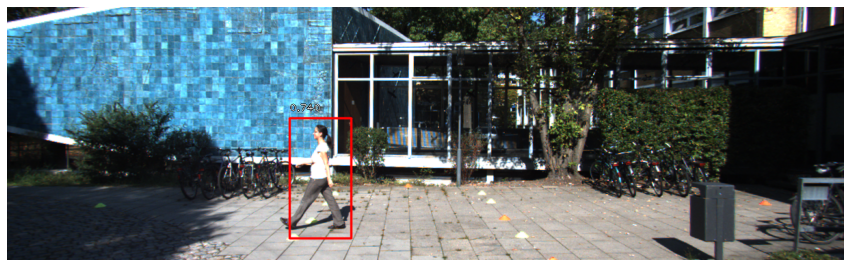

[  0.      204.12102 303.26016 369.12827]
303.26016 165.00725


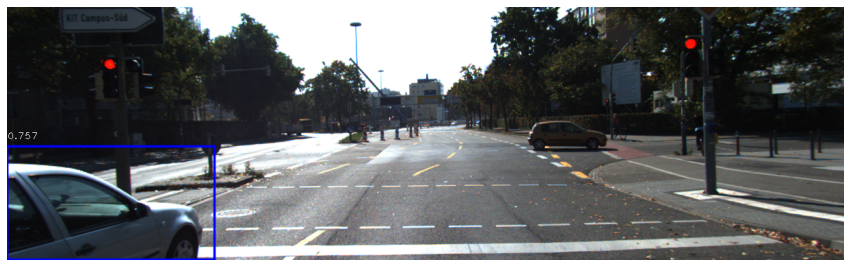

[ 733.80945    36.593876 1100.9453    372.0121  ]
367.13586 335.4182


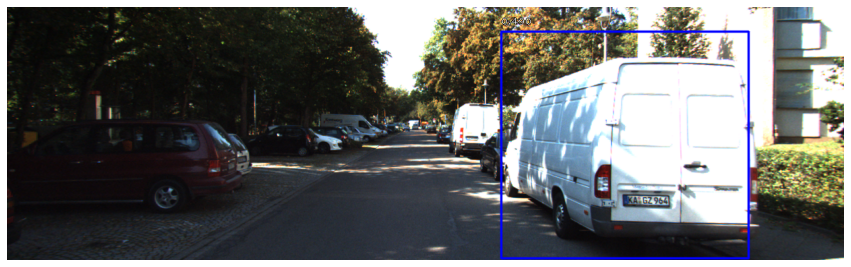

[ 865.7639   166.6313  1240.0787   367.45636]
374.31482 200.82506


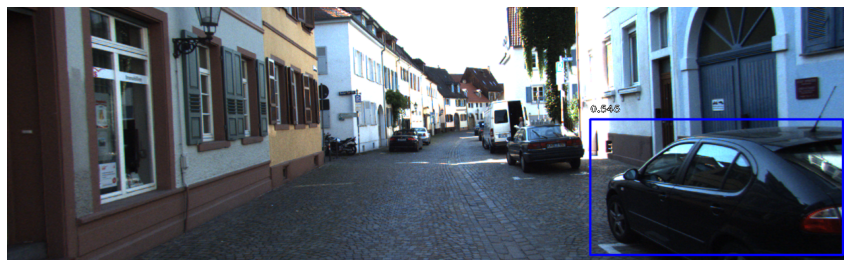

[593.57965 175.76308 625.64    206.28865]
32.060364 30.525574
[189.78738 130.66588 360.21967 233.77553]


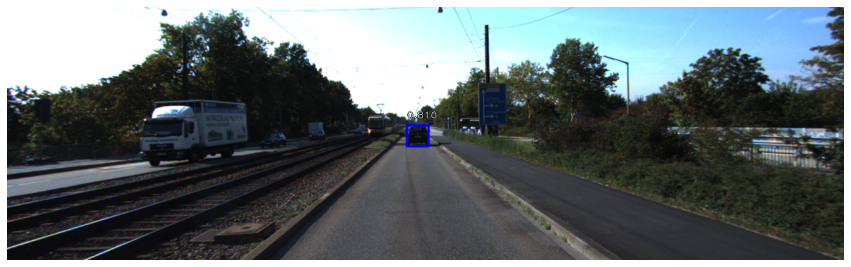

[627.16113 173.6316  669.17896 214.1734 ]
42.017822 40.541794
[516.4294  178.14412 569.47516 213.58815]


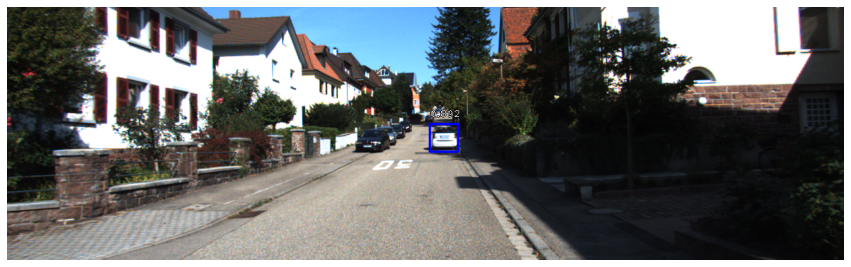

[805.12115 145.95961 893.2785  174.60979]


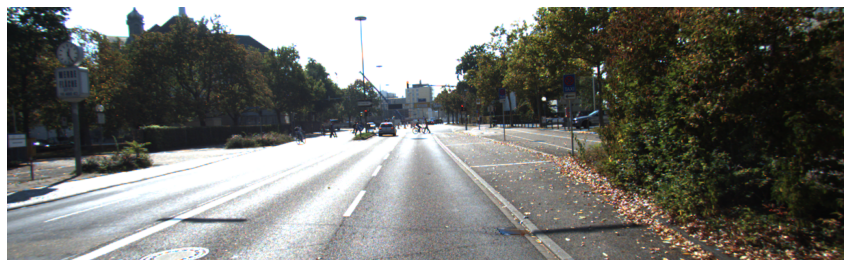

[694.1708  170.46341 793.88574 254.51207]


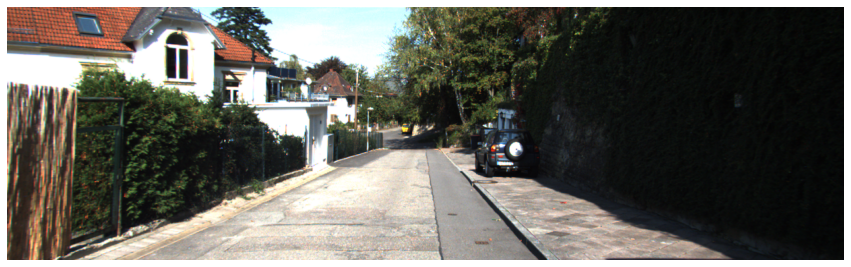

[  9.247628 185.76355  170.6913   325.42865 ]


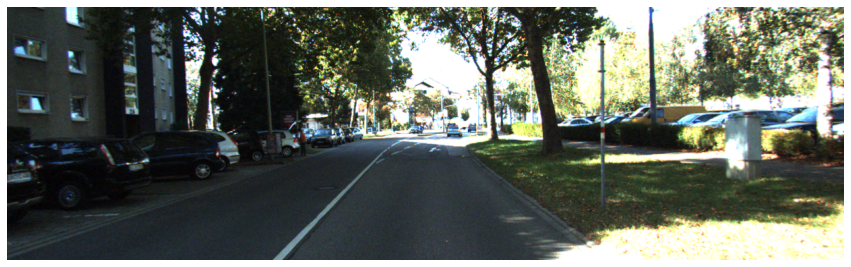

100점입니다.


In [220]:
test_system(self_drive_assist)

### 회고

모델 학습에서 일정 epoch 이후로는 더 이상 효과적인 학습이 진행되지 않았고, 그 결과 테스트 이미지들 내의 객체들을 완벽하게 인식하지 못했다.   
문제의 이미지에 대해 시스템이 객체를 정확히 인식하고 Go/Stop을 올바르게 반환하지 못한 이유는 그 이미지에 대한 모델의 예측 점수가 0.5보다 작기 때문이었다.   
그래서 임의로 반복문 탈출 조건을 'score < 그 모델의 점수보다 살짝 작은 값' 으로 설정했더니 점수는 100점이 나왔다.   
참고로 그냥 score < 0.5로 조건을 설정하면 점수는 90점이다.